# Simulation 3

**Mengqi Liu**

**Jul 17， 2023**

In [1]:
#from IPython.display import display_html
#display_html("""<button onclick="$('.input, .prompt, .output_stderr, .output_error').toggle();">Toggle Code</button>""", raw=True)

## Setting


- $d$: number of nodes 
- $s0$: expected number of edges 
- graph\_type: ER
    - ER: Erdős-Rényi Graph randomly choose one from all graphs with $d$ nodes and $s0$ edges + random orientation
    
- $n$: number of samples, n=inf mimics population risk 
- sem\_type: gauss, exp, gumbel, uniform, logistic, poisson
- loss\_type: l2, logistic
- lambda1: penalty for sparsity
- Here I use MCMC to simulate for 20 times.
- losses:
    - $h(W)=0$: constraint function
    - loss\_est: loss decided by loss\_type
    - loss\_l1: loss\_est + l1 penalty
    - obj\_new: + quadratic penalty of $h$
    - obj\_dual: dual function pertaining to obj\_new with Lagrange multiplier $\alpha$


## Results

### Gains during learning

 - The algorithm runs too slow when lambda1 is too small and the estimates are too coarse when lambda1 is too large.
 - When considering discrete distributions like poisson and logistic, we may choose loss_type to be 'logistic' or 'poisson' to achieve better performance (in terms of fdr, tpr, fpr, shd, nnz and hamming distance). However, the performance is not ideal (details in later).

### Experiment 1

Here I choose $d \in \{5, 10, 20, 40\}$, $s0=d$, lambda1$\in\{0.01, 0.1, 1, 5\}$ and compute losses with different $n \in \{2, 5, 7, 10, 15, 20\}$.

**Gains:**

 - obj\_aug $\approx$ loss\_l1 (h=0, constaint function is satisfied)
 - obj\_dual $\gtrapprox$ loss\_est
 - When loss\_type = l2,
   - Generally obj\_aug $>$ obj\_dual $\rightarrow$ **not strong duality**
   - Value of obj\_aug-obj\_dual will increase as $d$ increases, but basically does not increase as lambda1 increases $\rightarrow$ **The optimal solution is robust to lambda1, but not to $d$**
   - The loss_est keeps increasing when lambda1 increases $\rightarrow$ **Small lambda1 may lead to better optimal solution as well as sparse optimal solution**
   - The losses keep decreasing when $n$ decreases $\rightarrow$ **risk of overfitting**
   - Although the learning curves are normal for discrete distributions (poisson and logistic), but we should always be aware that the algorithm with loss\_type = l2 performs very poorly under these two distributions
 
 - When loss\_type = logistic,
   - Curves are only normal for logistic distribution when lambda1 is not too large or too small $\rightarrow$ **logistic loss is only suitable for logistic distribution and is sensitive to the choose of lambda1**



In [2]:
import numpy as np
import utils
import linear
import pandas as pd
import scipy
import math
import scipy
import matplotlib.pyplot as plt

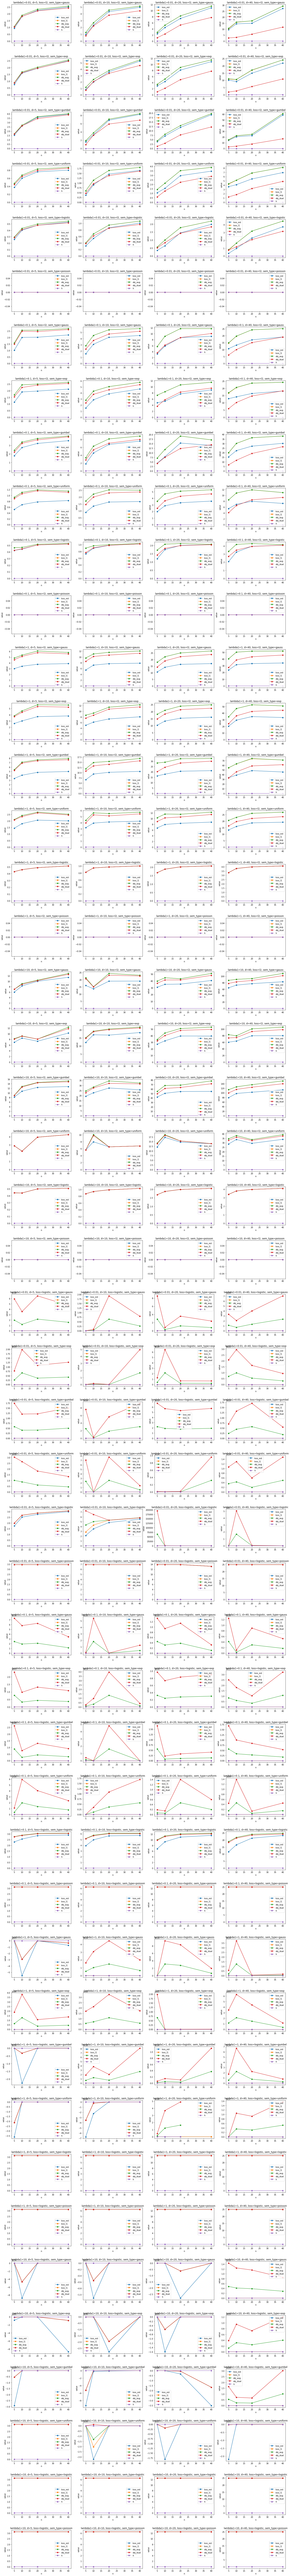

In [81]:
for i in range(20):
    if i == 0:
        result = pd.read_csv("./results_loss/result_"+str(i+7020)+".csv")
    else:
        result.iloc[:, 7:12] += pd.read_csv("./results_loss/result_"+str(i+7020)+".csv")
result.iloc[:, 7:12] /= 20
losses = ["loss_est", "loss_l1", "obj_aug", "obj_dual", "h"]
ds = [5, 10, 20, 40]
fig, axs = plt.subplots(nrows=48, ncols=4, figsize=(25, 240))
colormap = plt.cm.tab10
semtypes = ["gauss", "exp", "gumbel", "uniform", "logistic", "poisson"]
lambdas = [0.01, 0.1, 1, 10]
losstypes = ['l2', 'logistic']
for k, lambda1 in enumerate(lambdas):
    subset = result[result['lambda1'] == lambda1]
    for i, d in enumerate(ds):
        subset1 = subset[subset['d'] == d]
        for j, sem_type in enumerate(semtypes):
            sem_subset = subset1[subset1['sem_type'] == sem_type]
            for q, loss_type in enumerate(losstypes):
                subset2 = sem_subset[sem_subset['loss_type'] == loss_type]
                ax = axs[q*len(semtypes)*len(lambdas)+k*len(semtypes)+j, i]
                for p, loss_ in enumerate(losses):
                    ax.plot(subset2['n'], subset2[loss_], marker='o', label=loss_, color=colormap(p))
                ax.set_xlabel('n')
                ax.set_ylabel("value")
                ax.set_title(f'lambda1={lambda1}, d={d}, loss={loss_type}, sem_type={sem_type}')
                ax.legend()
plt.subplots_adjust(wspace=.2, hspace=.4)
plt.show()

### Experiment 2

Here I choose $d \in \{5, 10, 20, 30\}$, $s0=d$, lambda1$\in\{0.1, 1\}$ for continuous distributions with loss\_type = 'l2' and lambda1$\in\{0.01, 1\}$ for discrete distributions with loss\_type = 'logistic', and then compute losses with different $n \in \{5, 10, 20, 30\}$. The results are basically consistent with the conclusions in Experiment 1.

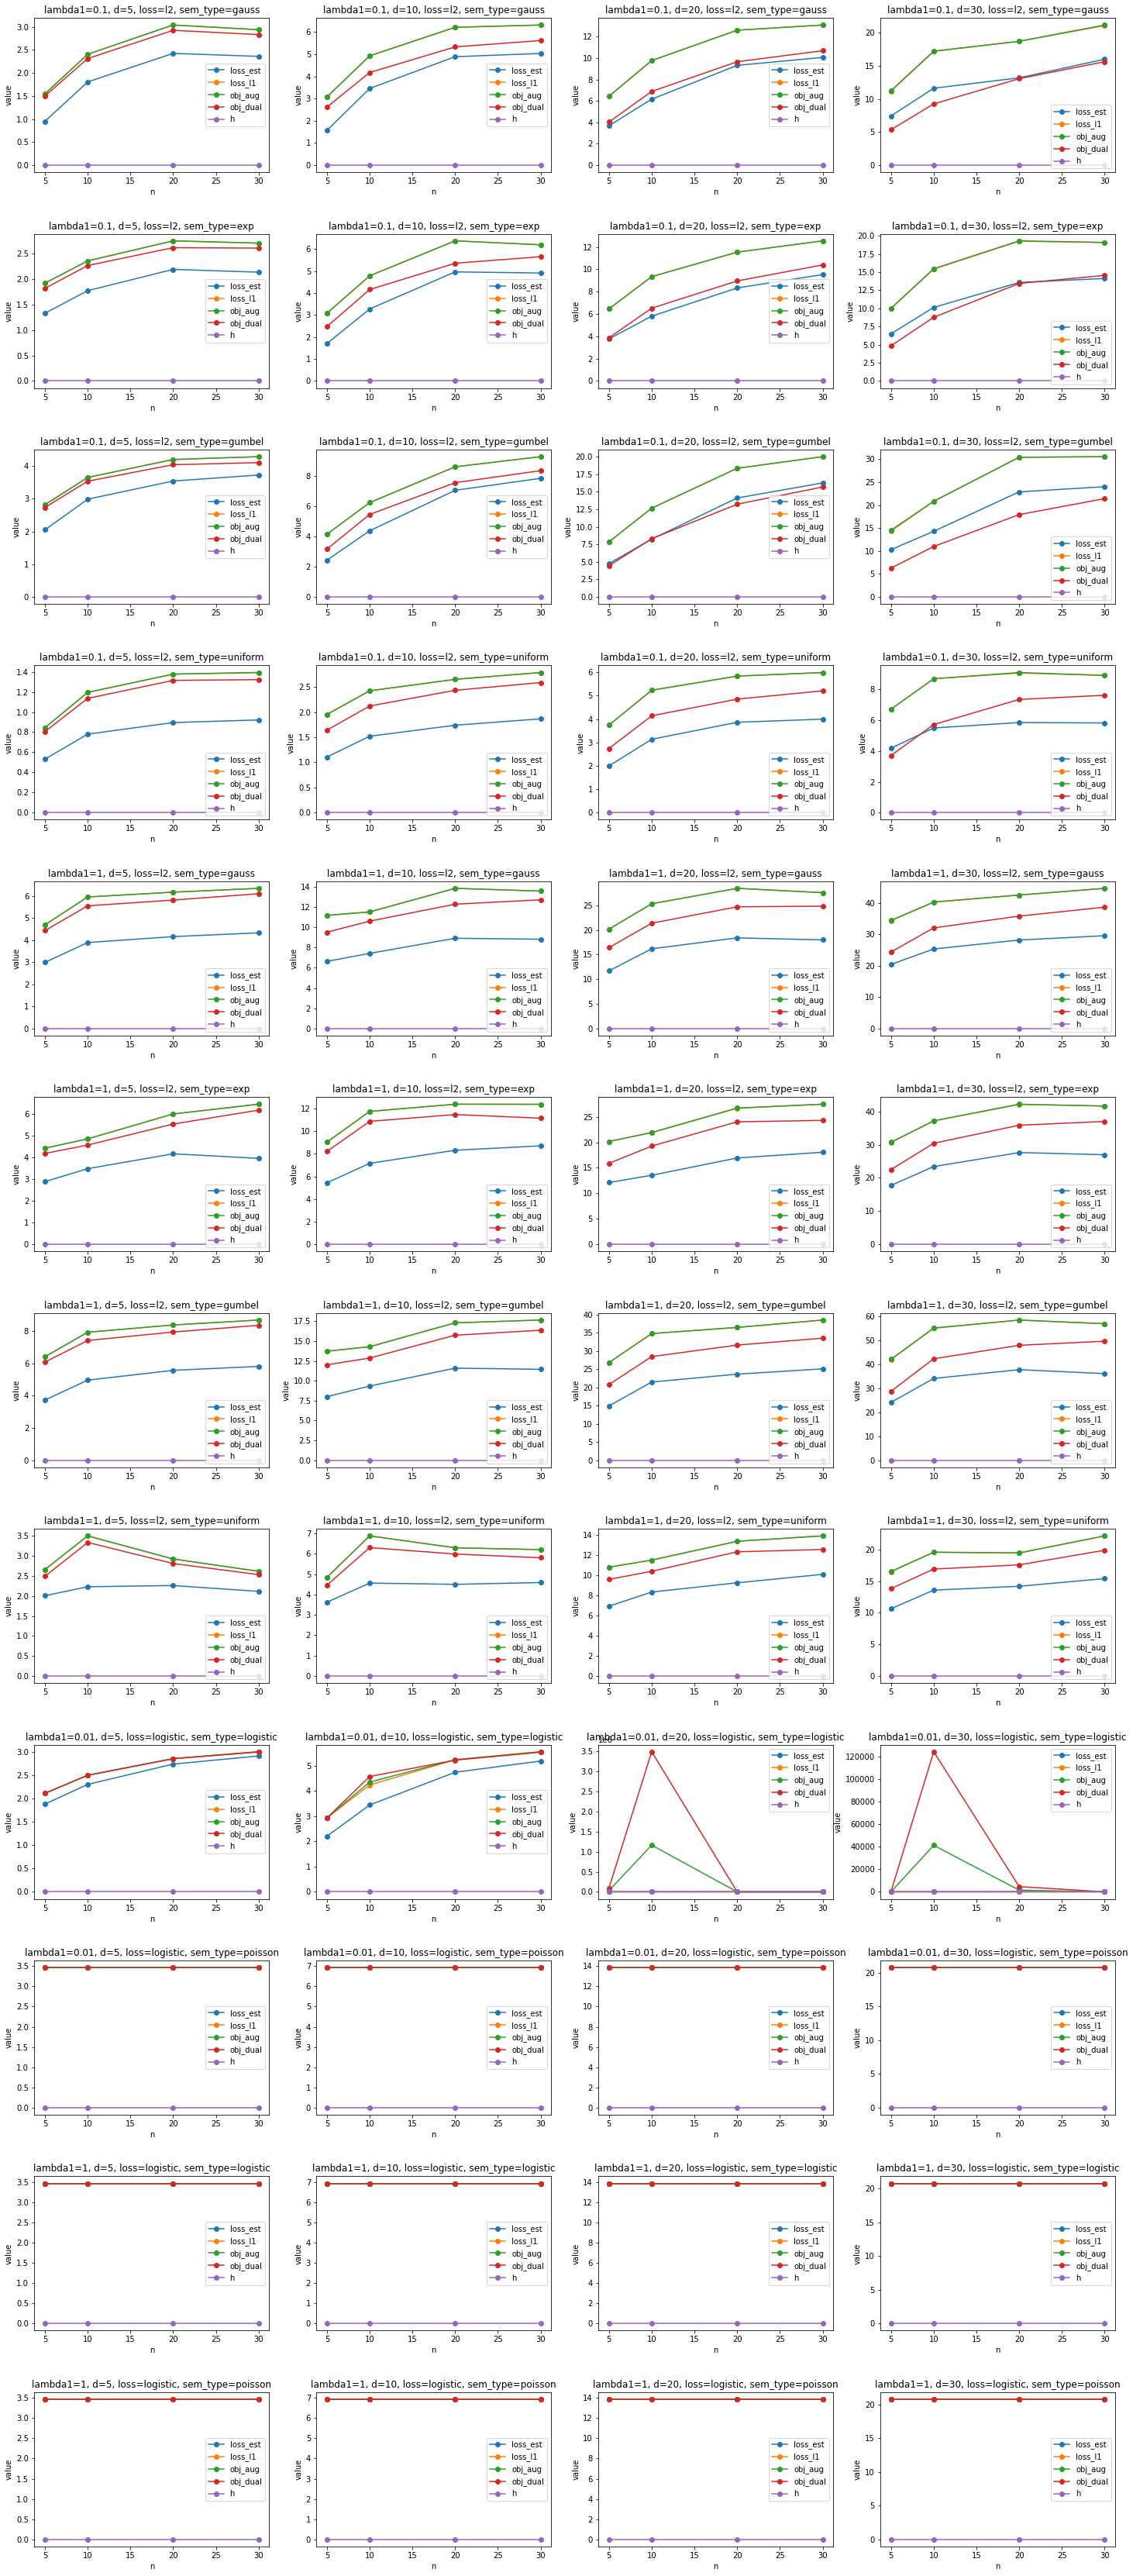

In [82]:
for i in range(20):
    if i == 0:
        result = pd.read_csv("./results_loss/result_"+str(i+7000)+".csv")
    else:
        result.iloc[:, 7:12] += pd.read_csv("./results_loss/result_"+str(i+7000)+".csv")
result.iloc[:, 7:12] /= 20
losses = ["loss_est", "loss_l1", "obj_aug", "obj_dual", "h"]
ds = [5, 10, 20, 30]
fig, axs = plt.subplots(nrows=12, ncols=4, figsize=(25, 60))
colormap = plt.cm.tab10
semtypes = ["gauss", "exp", "gumbel", "uniform"]
lambdas = [0.1, 1]
for k, lambda1 in enumerate(lambdas):
    subset = result[result['lambda1'] == lambda1]
    for i, d in enumerate(ds):
        subset1 = subset[subset['d'] == d]
        for j, sem_type in enumerate(semtypes):
            sem_subset = subset1[subset1['sem_type'] == sem_type]
            ax = axs[k*len(semtypes)+j, i]
            for p, loss_ in enumerate(losses):
                ax.plot(sem_subset['n'], sem_subset[loss_], marker='o', label=loss_, color=colormap(p))
            ax.set_xlabel('n')
            ax.set_ylabel("value")
            ax.set_title(f'lambda1={lambda1}, d={d}, loss=l2, sem_type={sem_type}')
            ax.legend()
semtypes = ["logistic", "poisson"]
lambdas = [0.01, 1]
for k, lambda1 in enumerate(lambdas):
    subset = result[result['lambda1'] == lambda1]
    for i, d in enumerate(ds):
        subset1 = subset[subset['d'] == d]
        for j, sem_type in enumerate(semtypes):
            sem_subset = subset1[subset1['sem_type'] == sem_type]
            ax = axs[8+k*len(semtypes)+j, i]
            for p, loss_ in enumerate(losses):
                ax.plot(sem_subset['n'], sem_subset[loss_], marker='o', label=loss_, color=colormap(p))
            ax.set_xlabel('n')
            ax.set_ylabel("value")
            ax.set_title(f'lambda1={lambda1}, d={d}, loss=logistic, sem_type={sem_type}')
            ax.legend()
plt.subplots_adjust(wspace=.2, hspace=.4)
plt.show()

### Experiment 3

Here I choose $d \in \{5, 10, 20\}$, $s0=d$, lambda1$\in\{0.01, 0.1, 1, 5\}$, loss\_type = 'l2' for continuous distributions and loss\_type = 'logistic' for discrete distributions , and then compute losses with different $n \in \{2, 5, 7, 10, 15, 20\}$. 

The purpose of doing this experiment is to observe the performance of the losses when $n$ and $d$ are relatively small.

**Gains**

 - When loss\_type = 'l2' and distributions are continuous, losses will approach 0.



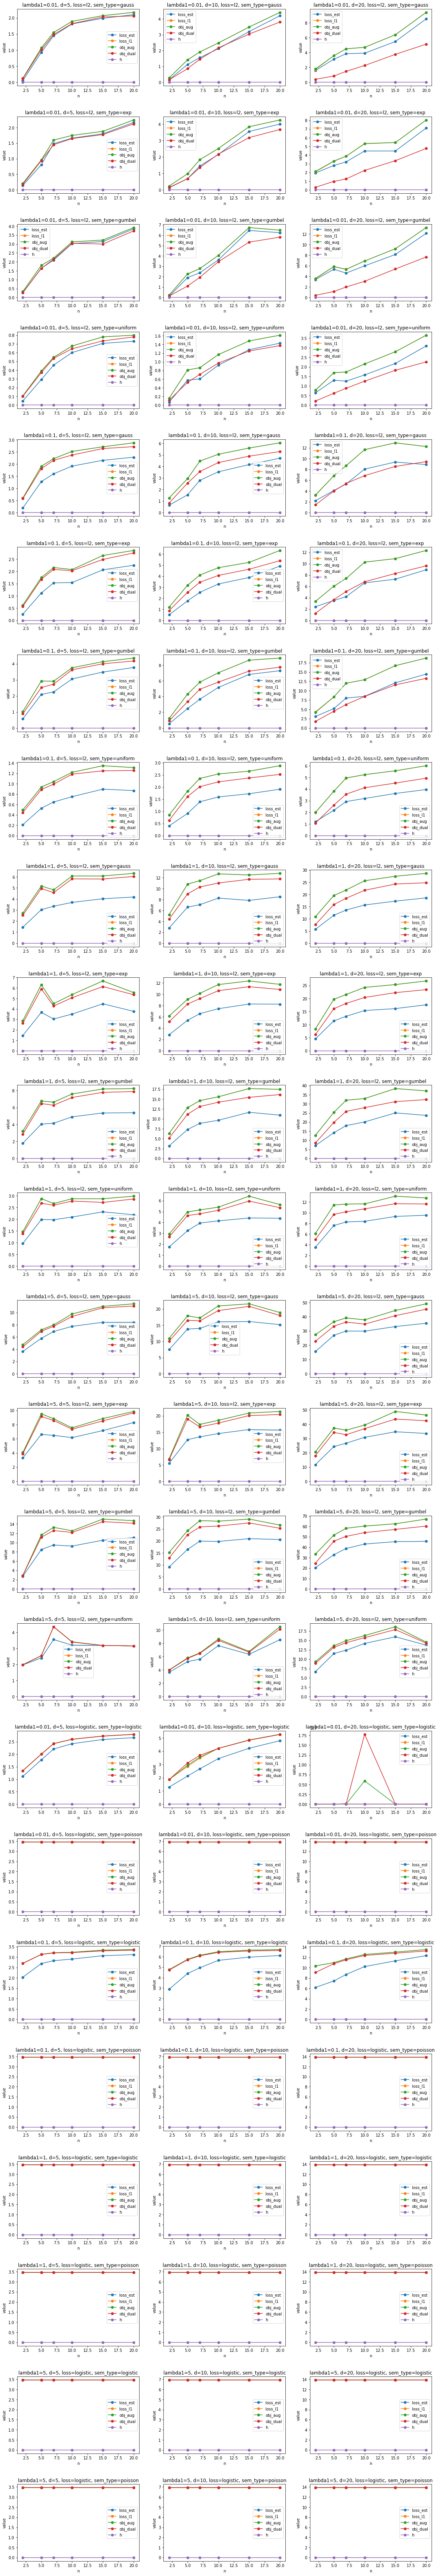

In [83]:
for i in range(20):
    if i == 0:
        result = pd.read_csv("./results_loss/result_"+str(i+8000)+".csv")
    else:
        result.iloc[:, 7:12] += pd.read_csv("./results_loss/result_"+str(i+8000)+".csv")
result.iloc[:, 7:12] /= 20
losses = ["loss_est", "loss_l1", "obj_aug", "obj_dual", "h"]
ds = [5, 10, 20]
fig, axs = plt.subplots(nrows=24, ncols=3, figsize=(19, 120))
colormap = plt.cm.tab10
semtypes = ["gauss", "exp", "gumbel", "uniform"]
lambdas = [0.01, 0.1, 1, 5]
for k, lambda1 in enumerate(lambdas):
    subset = result[result['lambda1'] == lambda1]
    for i, d in enumerate(ds):
        subset1 = subset[subset['d'] == d]
        for j, sem_type in enumerate(semtypes):
            sem_subset = subset1[subset1['sem_type'] == sem_type]
            ax = axs[k*len(semtypes)+j, i]
            for p, loss_ in enumerate(losses):
                ax.plot(sem_subset['n'], sem_subset[loss_], marker='o', label=loss_, color=colormap(p))
            ax.set_xlabel('n')
            ax.set_ylabel("value")
            ax.set_title(f'lambda1={lambda1}, d={d}, loss=l2, sem_type={sem_type}')
            ax.legend()
semtypes = ["logistic", "poisson"]
for k, lambda1 in enumerate(lambdas):
    subset = result[result['lambda1'] == lambda1]
    for i, d in enumerate(ds):
        subset1 = subset[subset['d'] == d]
        for j, sem_type in enumerate(semtypes):
            sem_subset = subset1[subset1['sem_type'] == sem_type]
            ax = axs[16+k*len(semtypes)+j, i]
            for p, loss_ in enumerate(losses):
                ax.plot(sem_subset['n'], sem_subset[loss_], marker='o', label=loss_, color=colormap(p))
            ax.set_xlabel('n')
            ax.set_ylabel("value")
            ax.set_title(f'lambda1={lambda1}, d={d}, loss=logistic, sem_type={sem_type}')
            ax.legend()
plt.subplots_adjust(wspace=.2, hspace=.4)
plt.show()

In [55]:
def summarize():
    for i in range(20):
        if i == 0:
            result = pd.read_csv("./results_loss/result_"+str(i+7000)+".csv")
        else:
            result.iloc[:, 7:12] += pd.read_csv("./results_loss/result_"+str(i+7000)+".csv")
    result.iloc[:, 7:12] /= 20
    return result

In [59]:
def plot_loss_1(loss_='loss_est'):
    result = summarize()
    ds = [5, 10, 20, 30]
    fig, axs = plt.subplots(nrows=len(ds), ncols=4, figsize=(15, 20))
    colormap = plt.cm.tab10
    semtypes = ["gauss", "exp", "gumbel", "uniform"]
    lambdas = [0.1, 1]
    for k, lambda1 in enumerate(lambdas):
        subset = result[result['lambda1'] == lambda1]
        for i, d in enumerate(ds):
            subset1 = subset[subset['d'] == d]
            ax = axs[k, i]
            for j, sem_type in enumerate(semtypes):
                sem_subset = subset1[subset1['sem_type'] == sem_type]
                ax.plot(sem_subset['n'], sem_subset[loss_], marker='o', label=sem_type, color=colormap(j))
            ax.set_xlabel('n')
            ax.set_ylabel(loss_)
            ax.set_title(f'lambda1={lambda1}, d={d}, loss=l2')
            ax.legend()
    semtypes = ["logistic", "poisson"]
    lambdas = [0.01, 1]
    for k, lambda1 in enumerate(lambdas):
        subset = result[result['lambda1'] == lambda1]
        for i, d in enumerate(ds):
            subset1 = subset[subset['d'] == d]
            ax = axs[2+k, i]
            for j, sem_type in enumerate(semtypes):
                sem_subset = subset1[subset1['sem_type'] == sem_type]
                ax.plot(sem_subset['n'], sem_subset[loss_], marker='o', label=sem_type, color=colormap(j))
            ax.set_xlabel('n')
            ax.set_ylabel(loss_)
            ax.set_title(f'lambda1={lambda1}, d={d}, loss=logistic')
            ax.legend()
    plt.subplots_adjust(wspace=.2, hspace=.4)
    plt.show()

In [67]:
def plot_loss_2(loss_='loss_est'):
    for i in range(20):
        if i == 0:
            result = pd.read_csv("./results_loss/result_"+str(i+8000)+".csv")
        else:
            result.iloc[:, 7:12] += pd.read_csv("./results_loss/result_"+str(i+8000)+".csv")
    result.iloc[:, 7:12] /= 20
    ds = [5, 10, 20]
    fig, axs = plt.subplots(nrows=8, ncols=3, figsize=(15, 20))
    colormap = plt.cm.tab10
    semtypes = ["gauss", "exp", "gumbel", "uniform"]
    lambdas = [0.01, 0.1, 1, 5]
    for k, lambda1 in enumerate(lambdas):
        subset = result[result['lambda1'] == lambda1]
        for i, d in enumerate(ds):
            subset1 = subset[subset['d'] == d]
            ax = axs[k, i]
            for j, sem_type in enumerate(semtypes):
                sem_subset = subset1[subset1['sem_type'] == sem_type]
                ax.plot(sem_subset['n'], sem_subset[loss_], marker='o', label=sem_type, color=colormap(j))
            ax.set_xlabel('n')
            ax.set_ylabel(loss_)
            ax.set_title(f'lambda1={lambda1}, d={d}, loss=l2')
            ax.legend()
    semtypes = ["logistic", "poisson"]
    for k, lambda1 in enumerate(lambdas):
        subset = result[result['lambda1'] == lambda1]
        for i, d in enumerate(ds):
            subset1 = subset[subset['d'] == d]
            ax = axs[4+k, i]
            for j, sem_type in enumerate(semtypes):
                sem_subset = subset1[subset1['sem_type'] == sem_type]
                ax.plot(sem_subset['n'], sem_subset[loss_], marker='o', label=sem_type, color=colormap(j))
            ax.set_xlabel('n')
            ax.set_ylabel(loss_)
            ax.set_title(f'lambda1={lambda1}, d={d}, loss=logistic')
            ax.legend()
    plt.subplots_adjust(wspace=.2, hspace=.4)
    plt.show()